In [27]:
import pandas as pd
import numpy as np
import os
import json
import re
from hashlib import sha512
from vega import VegaLite
from wordcloud import WordCloud
from IPython.display import display

def display_vg(spec):
    bundle = {}
    bundle['application/vnd.vegalite.v2+json'] = spec
    display(bundle, raw=True)
    
def mkdir(directory):
    """
    :param string directory: 
    :return: 
    """
    try:
        os.mkdir(directory)
    except FileExistsError:
        pass
    
def save_file(file_name, data):
    with open(file_name, "w") as f:
        f.write(data)
        

In [48]:
mkdir("../data/generated/")
mkdir("../data/generated/images")

In [3]:
def get_modules(root):
    modules = [item for item in os.listdir(root) if os.path.isdir(os.path.join(root, item))]
    
    return modules

modules = get_modules("../data/raw/modules")

modules

['MAT-10044', 'MAT-30023']

In [49]:
module = modules[0]
print(module)
mkdir("../data/generated/images/{0}".format(module))

output = {}
output["code"] = module

def get_grades(module):
    file = '../data/raw/modules/{0}/grades.csv'.format(module)
    with open(file, "r") as f:
        fline = f.readline()
        assessment_weights = [int(weight)/100 for weight in re.findall(r"\((.*?)%\)", fline)]
        
    grades = pd.read_csv(file, skiprows=[0])
    grades = grades[['#Ass#', 'Mark', '#Cand Key']]
    grades.columns = ['ass', 'grade', 'user']
    grades['user'] = grades['user'].str.replace(r'#|/[0-9]', '').apply(lambda u: sha512(u.encode('utf-8')).hexdigest())
    grades = grades.set_index('user')

    assessments = grades['ass'].unique()
    module_grades = pd.DataFrame([], index=grades.index.unique())

    for k, ass in enumerate(assessments):
        assessment_grades = grades[grades['ass'] == ass]['grade'].to_frame()
        assessment_grades.columns = [ass]
        assessment_grades['{0}_weighted'.format(ass)] = assessment_grades[ass] * assessment_weights[k]
        module_grades = module_grades.merge(assessment_grades, left_index=True, right_index=True, how="outer")

    module_grades = module_grades.fillna(0)
    module_grades['final_grade'] = module_grades.filter(regex="_weighted").sum(axis=1)
    
    return module_grades

module_grades = get_grades(module)

module_grades

MAT-10044


,#01,#01_weighted,#02,#02_weighted,final_grade
user,,,,,
0a628068de9c2a70f8685e318f5dbd07badc53704c8d7655949fda7415f195ec98c3a4d43e3957661f2fd0fce73b4814b58cf552cd35d1865cf6bf42f3e69565,96.0,76.8,89,17.8,94.6
0a6d48869596d53488f8838878198bf3caac38548d83ad7e14734297de4253f8199a814b7db1bab6091835250c7bdcc75acc14a1572f112a3967c79b1503013e,64.0,51.2,95,19.0,70.2
0a8e012a21baf4c32928caa65c149c2afd8a970a7a28820b215decefbe66778c28ae0af71c47544033919fb74846139140f9ec20dd5d8350cd3bcef2155391ff,85.0,68.0,83,16.6,84.6
18e4e11be10aaf08723ffb8f2f731ffb96d9ebdc5f38368f4b2f1e46b5f85a919d3f60d2daafcb07ead56fe24bfa63f6d13eff337a1e5f0b550c609e918bd8dc,79.0,63.2,87,17.4,80.6
1a70e13e29d382e20adf383c93d02fed2bf9b1855867b0d22415c983e81e7750f6da13abf1523d908362d4a5c8faff44b303f1c6b1572f0acf2013608633fc02,95.0,76.0,91,18.2,94.2
1aa5c99297b7f8811903ea4e5d6850aacc10e0bef961c358b4b2301991e1e8b6d31110d9c93c2a196ee0a986e231b12f2c463f8baa50521f9d12bb9a6354348f,19.0,15.2,73,14.6,29.8
1d0871384cde428db0cb59dc90c589f1321b665c7680100637a8e972276fe10556f2d185dbba8331b69ce4018157daf8acf6d5b2e14f9cefb5a0f49a10c1b82a,33.0,26.4,68,13.6,40.0
1f48ecb9da93119d0fd7261b181e8c2df5ca3fc5dad7a0f2f35b002a105bba38e9c2734618bcea992e61fb82786431010c74321b1494d24c0c9f9b52517ccb01,60.0,48.0,62,12.4,60.4
2a465669ace48ddd13fd780fa5ff3f95afcb79de06f53735987cc7a5a9e05708bc0685041ad02b16f2ef5912f043865eb99ff099a9d57c4d0db7c05fdeef7ea2,17.0,13.6,0,0.0,13.6


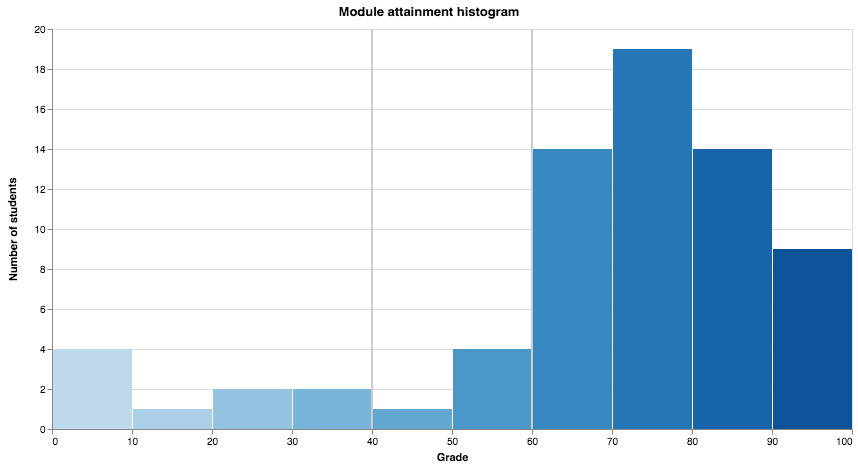

In [5]:
height = 400
width = 800

def build_grade_histogram(height, width, data):
    return VegaLite({
        "$schema": "https://vega.github.io/schema/vega-lite/v2.0.json",
        "title": "Module attainment histogram",
        "height": height,
        "width": width,
        "layer": [
            {
                "mark": "bar",
                "encoding": {
                    "x": {
                        "bin": { "step": 10 },
                        "field": "final_grade",
                        "type": "quantitative",
                        "axis": { "title": "Grade" }
                    },
                    "y": {
                        "aggregate": "count",
                        "type": "quantitative",
                        "axis": { "title": "Number of students" }
                    },
                    "color": {
                        "bin": { "step": 10 },
                        "field": "final_grade",
                        "type": "quantitative",
                        "legend": None
                    }
                }
            },
            {
                "mark": "rule",
                "encoding": {
                    "x": {
                        "value": width/100 * 40
                    },
                    "size": {
                        "value": 2
                    },
                    "color": {
                        "value": "#ccc"
                    }
                }
            },
            {
                "mark": "rule",
                "encoding": {
                    "x": {
                        "value": width/100 * 60
                    },
                    "size": {
                        "value": 2
                    },
                    "color": {
                        "value": "#ccc"
                    }
                }
            }
        ]
    }, data)

chart = build_grade_histogram(height, width, module_grades)
output["hist"] = chart.spec

display_vg(chart.spec)

In [6]:
def get_grade_stats(grades):
    stats = {}
    stats["median"] = round(grades['final_grade'].median(), 1)
    stats["gte70"] = int(grades[grades['final_grade'] >= 70]['final_grade'].count())
    stats["gte60"] = int(grades[grades['final_grade'] >= 60]['final_grade'].count() - stats["gte70"])
    stats["lte40"] = int(grades[grades['final_grade'] <= 40]['final_grade'].count())
    stats["zeros"] = int(grades[grades['final_grade'] == 0]['final_grade'].count())

    return stats

output["stats"] = get_grade_stats(module_grades)

output["stats"]

{'gte60': 14, 'gte70': 42, 'lte40': 10, 'median': 73.8, 'zeros': 2}

In [7]:
all_grades = [get_grades(module)["final_grade"] for module in modules]
average_grades = pd.DataFrame(pd.concat(all_grades, axis=1).mean(axis=1), columns=["average_grade"])
# random averages
# average_grades = pd.DataFrame((np.random.random_sample(module_grades.shape[0]) * 100).round(1), columns=["average_grade"], index=module_grades.index)
compare_grades = module_grades.merge(average_grades, left_index=True, right_index=True, how="left")

compare_grades.head()

,#01,#01_weighted,#02,#02_weighted,final_grade,average_grade
user,,,,,,
0a628068de9c2a70f8685e318f5dbd07badc53704c8d7655949fda7415f195ec98c3a4d43e3957661f2fd0fce73b4814b58cf552cd35d1865cf6bf42f3e69565,96.0,76.8,89,17.8,94.6,94.6
0a6d48869596d53488f8838878198bf3caac38548d83ad7e14734297de4253f8199a814b7db1bab6091835250c7bdcc75acc14a1572f112a3967c79b1503013e,64.0,51.2,95,19.0,70.2,70.2
0a8e012a21baf4c32928caa65c149c2afd8a970a7a28820b215decefbe66778c28ae0af71c47544033919fb74846139140f9ec20dd5d8350cd3bcef2155391ff,85.0,68.0,83,16.6,84.6,84.6
18e4e11be10aaf08723ffb8f2f731ffb96d9ebdc5f38368f4b2f1e46b5f85a919d3f60d2daafcb07ead56fe24bfa63f6d13eff337a1e5f0b550c609e918bd8dc,79.0,63.2,87,17.4,80.6,80.6
1a70e13e29d382e20adf383c93d02fed2bf9b1855867b0d22415c983e81e7750f6da13abf1523d908362d4a5c8faff44b303f1c6b1572f0acf2013608633fc02,95.0,76.0,91,18.2,94.2,94.2


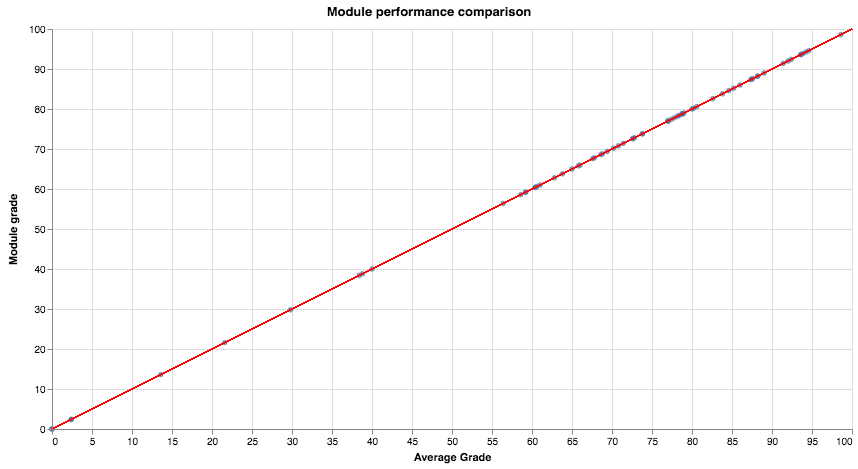

In [8]:
def build_grade_comparison_plot(height, width, data):
    return VegaLite({
        "$schema": "https://vega.github.io/schema/vega-lite/v2.0.json",
        "title": "Module performance comparison",
        "height": height,
        "width": width,
        "layer": [
            {
                "mark": "circle",
                "encoding": {
                    "x": {
                        "field": "average_grade",
                        "type": "quantitative",
                        "axis": { "title": "Average Grade" }
                    },
                    "y": {
                        "field": "final_grade", 
                        "typs": "quantitative",
                        "axis": { "title": "Module grade" }
                    }
                }
            },
            {
                "mark": "rule",
                "encoding": {
                    "x": {
                        "value": 0
                    },
                    "y": {
                        "value": height
                    },
                    "size": {
                        "value": 1
                    },
                    "color": {
                        "value": "red"
                    }
                }
            }
        ]
    }, data)
        
chart = build_grade_comparison_plot(height, width, compare_grades)
output["compare"] = chart.spec

display_vg(chart.spec)

## Multiple choice questions

In [9]:
mc_questions = [
    "1. Staff are good at explaining things",
    "2. The module was well organised.",
    "3. On this module, I have received sufficient advice and support with my studies.",
    "4. The module was interesting and engaging",
    "5. Practical / tutorial / workshop sessions were helpful.",
    "6. Useful support materials were made available on the KLE",
    "7. Overall, I am satisfied with the quality of this module. ",
]
mc_answers = [
    "Strongly Agree",
    "Agree",
    "Disagree",
    "Strongly Disagree",
    "N/A"
]

def get_student_multi_choice_feedback(module, questions, answers):
    fb = pd.read_csv("../data/raw/modules/{0}/feedback.csv".format(module))
    fb_answers = pd.DataFrame(fb[questions])
    fb_answers = pd.DataFrame(fb_answers.apply(pd.value_counts))
    answers = pd.DataFrame(answers, columns=["answer"])
    answers = pd.DataFrame(answers).merge(fb_answers, left_on="answer", right_index=True, how="left").fillna(0)
    answers.columns = ["answer"] + ["q{0}".format(i+1) for i in range(len(questions))]
    
    return answers

sfb = get_student_multi_choice_feedback(module, mc_questions, mc_answers)

sfb

,answer,q1,q2,q3,q4,q5,q6,q7
0,Strongly Agree,39.0,38.0,25.0,26.0,32.0,30.0,32.0
1,Agree,17.0,18.0,30.0,27.0,19.0,23.0,23.0
2,Disagree,0.0,0.0,1.0,2.0,4.0,3.0,1.0
3,Strongly Disagree,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,N/A,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Additional comments for multiple choice questions

In [10]:
def get_textual_student_feedback(module):
    fb = pd.read_csv("../data/raw/modules/{0}/feedback.csv".format(module))
    fb = fb.filter(regex=r"additional comments", axis=1)
    
    text_fb = []
    for col in fb:
        text_fb.append(fb[col].dropna().tolist())
    
    return text_fb
    
get_textual_student_feedback(module)

[['Answers questions well',
  'He explains why he does everything which is good because it helps us to understand problems. ',
  'He always explains questions I am stuck on really well.',
  "Martyn was very good at explaining the only reason this isn't strongly agree is because of the difficulty of the module.",
  'Martyn is we very clear during lectures and weekly tutorials helped in grasping difficult concepts.',
  'always clear and confirms understanding'],
 ['Great balacnce of lectures and tutorials.',
  'we always know whats coming up',
  'Before assignments are given out would useful to have an opportunity to have a question given that can be marked so we know what sort of things to look for.'],
 ['Possibly more staff to work through problems with.',
  'Possibly more staff to work through problems with.',
  'I found the lectures where we went through the assignments and the class test extremely helpful',
  'always helpful comments and feedback from work'],
 ['Decent amount of typ

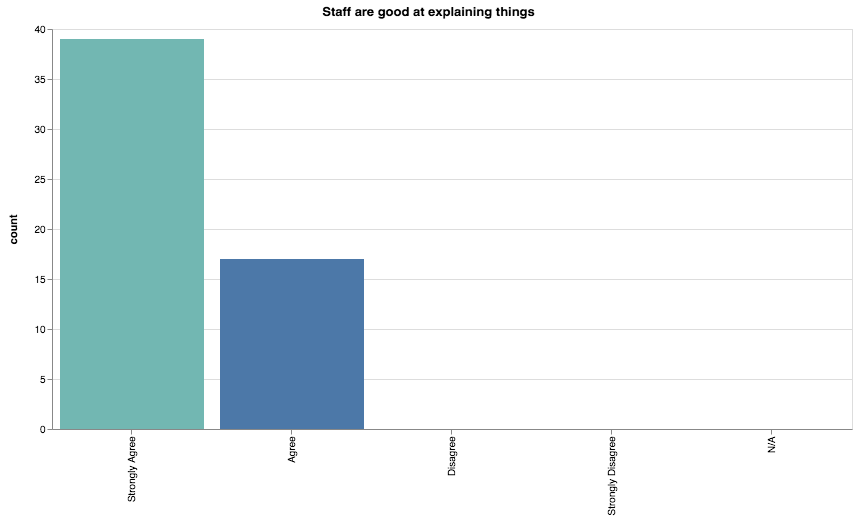

In [11]:
def build_student_feedback_histogram(height, width, data, questions, question):
    return VegaLite({
        "$schema": "https://vega.github.io/schema/vega-lite/v2.0.json",
        "title": re.sub(r"\d.\s", "", questions[question-1]),
        "height": height,
        "width": width,
        "mark": "bar",
        "encoding": {
            "x": {
                "field": "answer",
                "type": "nominal",
                "sort": None,
                "axis": { "title": "" }
            },
            "y": {
                "field": "q{0}".format(question),
                "type": "quantitative",
                "axis": { "title": "count" }
            },
            "color": {
                "field": "answer",
                "type": "nominal",
                "legend": None,
            }
        }
    }, data)

chart = build_student_feedback_histogram(height, width, sfb, mc_questions, 1)
output["feedback"] = chart.spec

display_vg(chart.spec)

## Descriptive questions

In [25]:
desc_questions = [
    "8. Was there anything in particular which you enjoyed in this module? ",
    "9. If you could improve one thing about this module, what would it be?"
]

def get_descriptive_student_feedback(module, questions):
    fb = pd.read_csv("../data/raw/modules/{0}/feedback.csv".format(module))
    fb = fb.filter(questions, axis=1)
    
    desc_fb = []
    for col in fb:
        desc_fb.append(fb[col].dropna().str.cat(sep=" "))
    
    return desc_fb
    
dfb = get_descriptive_student_feedback(module, desc_questions)
dfb

['I enjoyed the module as a whole as I found it challenging and engaging No EVERYTHING  Tutorials  .. Tutorials and having gapped notes  Martyn <3 Lots of problems Lots of problems The lecturer  Solutions fully gone through in class for examples Practice sessions were useful. Everything The lectures were enjoyable this was down to the lecturer  Learning new ways to solve problems  The workshops are really good because martyn is really good at answering any querries on questions and helping you find a strting point. Problem solving The test. The entire module was the most enjoyable, interesting and informative out of all of them. Lecturer was very good I enjoyed the way the problems were set out and how the solutions were explained to us Going through lots of examples The style of questions, and Martyn of course No Interesting problems  Tutorials and working out questions in groups  Developing new skills in being able to approach unfamiliar problems The tutorial sessions The lecturer ma

In [50]:
def build_word_cloud(text):
    return WordCloud(background_color="black", colormap="GnBu", height=height, width=width, font_path="fonts/caveat.ttf").generate(text)

wordcloud = build_word_cloud(dfb[0])
# wordcloud.to_image()
wordcloud.to_file("../data/generated/images/{0}/{1}.png".format(module, desc_questions[0][0]))

In [13]:
# save_file("../data/generated/{0}.json".format(module), json.dumps(output))
# output